In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

# Ноутбук для ДЗ №4 обработка временных последовательностей RNN
В данном дз вам будут данных времменая последовательно, которая описывает распределение хитов по времени за несколько лет. Вам нужно будет обучить модель RNN на исторических данных и потом сделать предсказание для "будущего" года, в текущей задаче это 2019 год

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [6]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [7]:
data_train = read_set('train.csv')
data_test =  read_set('derived.csv')
data_sample = read_set('sample_submission.csv')

### Проверим наши данные, что мы загрузили

In [8]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [9]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [10]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [11]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

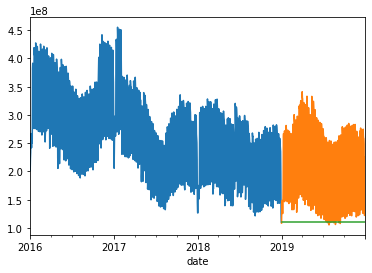

In [12]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_sample['value'].plot(kind = 'line')
plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [13]:
# обучаем модель
arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=1.65 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=0.64 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=1.48 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=2.47 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.125, Time=1.87 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=3.58 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=3.35 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=2.44 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=2.23 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.291, Time=4.61 sec
 ARIMA(2,0,3)(2,0,2

In [14]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [15]:
prediction = prediction .rename(columns = {0:'value'})

смотрим, что она нам предсказала

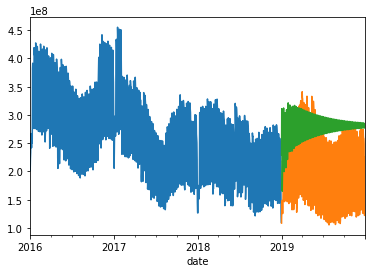

In [16]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line')
plt.show()

### Функция подсчета метрик для конкурса

In [17]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [18]:
MAPE(data_test, prediction)

39.83962687349625

In [19]:
MAPE(data_test, data_sample)

44.81735178659308

## Из пандас строим датасет

In [52]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

stats = Stats(data_train)

In [53]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        # будем обучать окнами, поэтому сделаем отступ
        self._len = len(data) - seq_len + 1
        # также будем нормализовывать наши таргеты  
        self.mean = stats.mean
        self.std = stats.std
        self.data = (data- self.mean) / self.std 
        self.seq_len = seq_len
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        for row in  d.iterrows():
            targets += [ row[1]['value'] ]
            days += [ row[0].day ]
            months += [row[0].month]
            year += [row[0].year]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(year), \
               torch.FloatTensor(targets)

In [58]:
ds_train = TSDataset(data_train, 10) 
ds_test  = TSDataset(data_test, 10)

## Теперь нужно определить нашу модель 

In [67]:
# нужно реализовать модель
class TimeSeriesModel(nn.Module):
    
        def __init__(self, hidden_size, input_sizes):            
            super().__init__()
            pass
            
        def forward(self, batch, ctx = None):
            pass
            # возвращаем выход и контекст, в инкрементальном режиме генерации он нам потребуется
            return output, ctx
        

### Определяем даталоадеры для теста и трейна

In [60]:
dl_train = DataLoader(ds_train, 8 , True)
dl_test = DataLoader(ds_test, 8 , False)

In [61]:
series_model = TimeSeriesModel(32, (4,4))

In [62]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=1e-4)

In [63]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./series_runs/')

### Обучаем модель

In [64]:
global_epoch = 0
global_iter = 0

In [65]:
# функция тестирование модели
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    return sum_loss

In [66]:
# модель обучаем в режиме teacher forcing, т.е. на вход подаем сразу всю последовательность,
# на выходе таргет должен быть смещен на один временной шаг, чтобы правильно считался лосс
for epoch in range(0, 100):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:,1:]
        result, _ = series_model(batch)        
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
    # тестируем модель
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████| 42/42 [00:00<00:00, 43.29it/s]


In [42]:
# сохраняем модель
torch.save(series_model.state_dict(), 'series_model2.ptx')

In [43]:
# восстанавливаем модель
series_model = TimeSeriesModel(32, (4,4))
series_model.load_state_dict(torch.load('series_model2.ptx'))

<All keys matched successfully>

### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должгны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.